In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from  itertools import chain
from textblob import TextBlob
import seaborn as sns

In [2]:
df = pd.read_pickle('appReviews_dataset_final.pkl')

In [3]:
len(df)

2373038

# Additional Cleaning and Data Filtering

In [4]:
#removing apps and their reviews if the app has less than 30 reviews
df_count = df.groupby('AppId').count()
df_count = pd.DataFrame(df_count).reset_index()
df_count = df_count.rename(columns={'index':'Score'})
df_count = df_count.sort_values('ReviewId')
df_count = df_count.drop(df_count[df_count.ReviewId >29].index)
lowReviews_list = list(df_count['AppId'])

df = df[~df['AppId'].isin(lowReviews_list)]
len(df)

2369761

# Tokenizing Review Text

In [5]:
#remove non alphabetic chars
df['ReviewTextTokenized'] = df.ReviewText.str.replace("[^a-zA-Z\' ]", '', regex=True)

#replace any new line marks with a space
df['ReviewTextTokenized'] = df['ReviewTextTokenized'].replace('\n',' ')

#convert to lower case
df['ReviewTextTokenized'] = df.ReviewTextTokenized.str.lower()

In [6]:
#tokenize
df['ReviewTextTokenized'] = df.apply(lambda row: nltk.word_tokenize(row['ReviewTextTokenized']), axis=1)

# Removing Stopwords from the Tokenised Reviews

In [7]:
def remove_stopwords(textList):
    result=[]
    
    for i in range(len(textList)):
        noAdd=False
        for ii in range(len(stop)):
            if(stop[ii] == textList[i]):
                noAdd=True
        if(noAdd==False):
            if(textList[i] not in result):
                result.append(textList[i])
    result = set(result)
    return list(result)

In [8]:
#remove stopwords
stop = stopwords.words('english')
#added a few extra stopwords to the list
extraWords = ['n\'t','\'s','\'m','\'ve','\'d','\'ll','ca','wo','im','na','app']
for i in extraWords:
    stop.append(i)

df['ReviewTextTokenized'] = df['ReviewTextTokenized'].apply(remove_stopwords)

In [9]:
#convert scores to float values
df["AppScore"] = pd.to_numeric(df["AppScore"], downcast="float")
df["Score"] = pd.to_numeric(df["Score"], downcast="float")

In [10]:
df.head(3)

,AppId,AppScore,Price,AdSupported,OffersIAP,InAppProductPrice Low,InAppProductPrice High,Genre,SubGenre,ReviewId,Username,ReviewText,Score,ThumbsUpCount,ReviewCreatedVersion,ReceivedReply,Time,ReviewTextTokenized
0,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOFmCWceVoFZy8SeT12c-I66JbSj0Nf7-hnVE4B...,Malesha Hasan,Excellent app to use. No problems.,5.0,0,105.0,False,2022-04-09 18:23:54,"[problems, use, excellent]"
1,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOE7iZydz6Vu-dbOYpLejv8suWqfV0x9dVhIg05...,Melanie Zokem,Stronger Good but slow,5.0,0,104.0,False,2022-04-09 18:16:21,"[slow, good, stronger]"
2,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOEzc9TbIqE7koJWizuWQy-ot_uB_od_CBQ3Tai...,JOHN JACOB,Submitted many times,5.0,0,105.0,False,2022-04-09 18:07:13,"[times, submitted, many]"


# App Scores compared to the mean App Review Score

The App Score is displayed on the google play store next to the app, it is based on the app's current quality ratings from user reviews. The mean App Review Score is calculated by averaging the scores from all the reviews for an app in my dataset. The review data in the dataset is taken from the most recent reviews for an app.

In [11]:
reviewScore = df.groupby('AppId').mean()
reviewScore = reviewScore.drop(reviewScore[reviewScore.AppScore == 0].index)
reviewScore.head(5)

,AppScore,InAppProductPrice Low,InAppProductPrice High,Score
AppId,,,,
AutomateIt.mainPackage,3.416667,1.79,0.00,3.398382
OCTech.Mobile.Applications.OBDLink,3.703704,15.99,79.99,4.036036
ae.hsbc.hsbcuae,4.333333,0.00,0.00,2.927894
aero.skydemon.skydemonandroid,4.588235,0.00,0.00,4.455782
ai.cloudmall.android,1.600000,0.00,0.00,4.192192


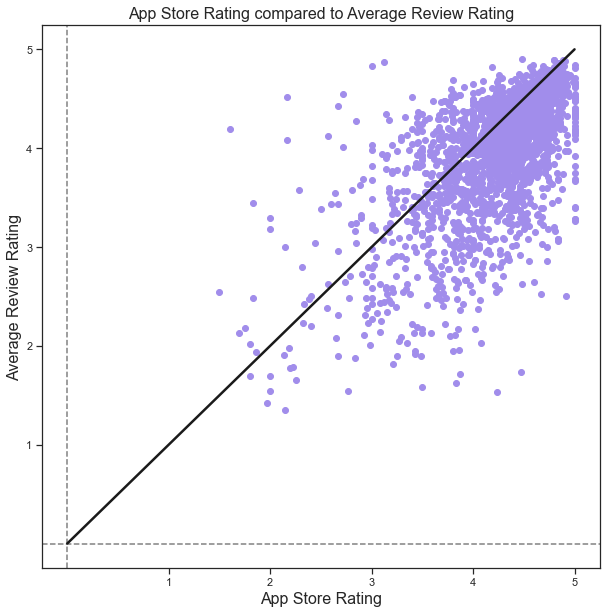

In [12]:
# Scatter plot
sns.set_theme(style="ticks")
plt.figure(figsize=(10, 10))
plt.xlabel('AppScore', fontsize=18)
plt.ylabel('Score', fontsize=16)
plt.axvline(0,c=(0.5,0.5,0.5), ls='--')
plt.axhline(0,c=(0.5,0.5,0.5), ls='--')
plt.yticks([1,2,3,4,5],['1','2','3','4','5'])
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.scatter(reviewScore['AppScore'],reviewScore['Score'],color='#A18DEB')
plt.title('App Store Rating compared to Average Review Rating', fontsize=16)
plt.xlabel('App Store Rating', fontsize=16)
plt.ylabel('Average Review Rating', fontsize=16)

plt.plot([0,5], [0,5], color="k", lw=2.5)

plt.show()

Plotting the App Scores against the Mean App Review Scores can tell us that the Mean App review score is not representative of an app's current Google Play Store Score. 
All the analysis in future graphs will use Mean App review scores rather than app scores, whenever App Scores are mentioned, it is refering to the mean app review score.

# Sentiment

In [13]:
def sentimentCalculate(text):
    text = ' '.join(text)
    blob = TextBlob(text)
    return blob.sentiment[0]

In [14]:
df['TextSentiment'] = df['ReviewTextTokenized'].apply(sentimentCalculate)
df.head(3)

,AppId,AppScore,Price,AdSupported,OffersIAP,InAppProductPrice Low,InAppProductPrice High,Genre,SubGenre,ReviewId,Username,ReviewText,Score,ThumbsUpCount,ReviewCreatedVersion,ReceivedReply,Time,ReviewTextTokenized,TextSentiment
0,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOFmCWceVoFZy8SeT12c-I66JbSj0Nf7-hnVE4B...,Malesha Hasan,Excellent app to use. No problems.,5.0,0,105.0,False,2022-04-09 18:23:54,"[problems, use, excellent]",1.0
1,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOE7iZydz6Vu-dbOYpLejv8suWqfV0x9dVhIg05...,Melanie Zokem,Stronger Good but slow,5.0,0,104.0,False,2022-04-09 18:16:21,"[slow, good, stronger]",0.2
2,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOEzc9TbIqE7koJWizuWQy-ot_uB_od_CBQ3Tai...,JOHN JACOB,Submitted many times,5.0,0,105.0,False,2022-04-09 18:07:13,"[times, submitted, many]",0.5


# Does Review Sentiment correlate to Review Score?

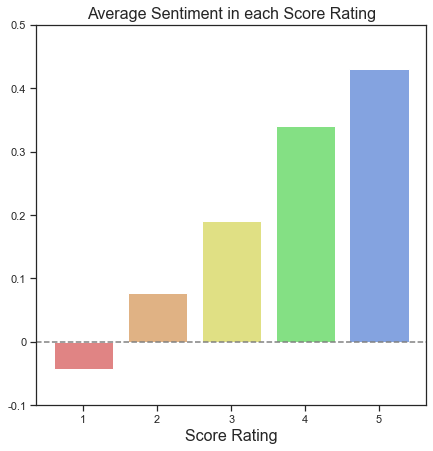

In [15]:
df_means = df.groupby('Score').mean()
df_means = pd.DataFrame(df_means).reset_index()
df_means = df_means.drop(df_means[df_means.Score == 0].index)
df_means = df_means.rename(columns={'index':'Score'})
df_means = df_means.sort_values('TextSentiment')

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(7, 7))
plt.axhline(0,c=(0.5,0.5,0.5), ls='--')
ax.bar([1,2,3,4,5], df_means['TextSentiment'], color=[(0.8, 0.2, 0.2, 0.6),
                                                                        (0.8, 0.5, 0.2, 0.6),
                                                                        (0.8, 0.8, 0.2, 0.6),
                                                                        (0.2, 0.8, 0.2, 0.6),
                                                                        (0.2, 0.4, 0.8, 0.6)])

plt.yticks([-0.1,0,0.1,0.2,0.3,0.4,0.5],
           [-0.1,0,0.1,0.2,0.3,0.4,0.5])
plt.title('Average Sentiment in each Score Rating', fontsize=16)
plt.xlabel('Score Rating', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

# Does App Sentiment correlate to App Score?
App Sentiment is the average sentiment across all the reviews for an app.

In [16]:
#new condensed dataframe
df_con = pd.DataFrame()
df_con['AppId'] = df['AppId']
df_con['Score'] = df['Score']
df_con['Genre'] = df['Genre']
df_con['TextSentiment'] = df['TextSentiment']
df_con = df_con.sort_values('AppId')

#converting all review scores for an app into a single column in the new condensed dataframe
df_con2 = pd.DataFrame(df_con.groupby('AppId')['Score'].mean())
df_con2 = pd.DataFrame(df_con2).reset_index()
df_con2 = df_con2.drop(df_con2[df_con2.Score == 0].index)
df_con2 = df_con2.rename(columns={'index':'AppId'})
df_con2 = df_con2.sort_values('AppId')

#converting all sentiment scores for an app into a single column in the new condensed dataframe
df_con3 = pd.DataFrame(df_con.groupby('AppId')['TextSentiment'].mean())
df_con3 = pd.DataFrame(df_con3).reset_index()
df_con3 = df_con3.drop(df_con3[df_con3.TextSentiment == 0].index)
df_con3 = df_con3.rename(columns={'index':'AppId'})
df_con3 = df_con3.sort_values('AppId')

#counts of apps' reviews
df_count = df.groupby('AppId')['ReviewId'].count()
df_count = pd.DataFrame(df_count).reset_index()
df_count = df_count.sort_values('AppId')

df_con = df_con.drop_duplicates(subset=['AppId'])
df_con = df_con.drop(columns=['Score'])
df_con = df_con.drop(columns=['TextSentiment'])

df_con_full = df_con.merge(df_con2, how='inner', on='AppId')
df_con_full = df_con_full.merge(df_con3, how='inner', on='AppId')
df_con_full = df_con_full.merge(df_count, how='inner', on='AppId')
df_con_full = df_con_full.rename(columns={'ReviewId':'ReviewCount'})
df_con_full = df_con_full.sort_values('ReviewCount')
df_con_full

,AppId,Genre,Score,TextSentiment,ReviewCount
668,com.deltadore.tydom,Lifestyle,2.066667,0.011050,30
636,com.dacia.mydacia.one.fr,Auto & Vehicles,2.466667,0.103963,30
2592,holecek.pavel.MorseCode,Tools,4.733333,0.474915,30
2921,qa.hsbc.hsbcqatar,Finance,2.741935,0.121901,31
772,com.elladagames.niffelheim,Games,4.193548,0.172720,31
...,...,...,...,...,...
1157,com.instagram.android,Social,3.858510,0.294074,4389
2010,com.snapchat.android,Communication,3.843806,0.287018,4456
1234,com.justeat.app.ie,Food & Drink,3.708709,0.273971,4995
1868,com.revolut.revolut,Finance,4.073000,0.354982,6000


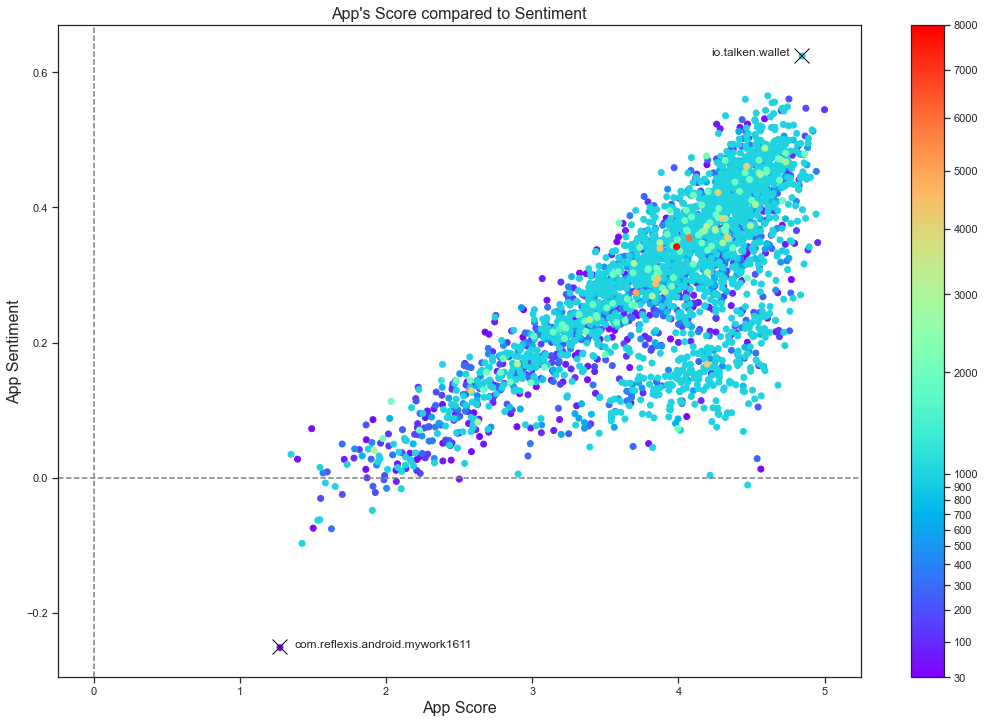

In [17]:
# Scatter plot
sns.set_theme(style="ticks")
plt.figure(figsize=(18, 12))
plt.axvline(0,c=(0.5,0.5,0.5), ls='--')
plt.axhline(0,c=(0.5,0.5,0.5), ls='--')
sc = plt.scatter(df_con_full['Score'],df_con_full['TextSentiment'],c=np.sqrt(df_con_full['ReviewCount']),cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks([np.sqrt(30),np.sqrt(100),np.sqrt(200),np.sqrt(300),np.sqrt(400),np.sqrt(500),
              np.sqrt(600),np.sqrt(700),np.sqrt(800),np.sqrt(900),np.sqrt(1000),
              np.sqrt(2000),np.sqrt(3000),np.sqrt(4000),np.sqrt(5000),np.sqrt(6000),np.sqrt(7000),np.sqrt(8000)])
cb.ax.set_yticklabels(['30','100','200','300','400','500','600','700','800','900',
                       '1000','2000','3000','4000','5000','6000','7000','8000'])

plt.title('App\'s Score compared to Sentiment', fontsize=16)
plt.xlabel('App Score', fontsize=16)
plt.ylabel('App Sentiment', fontsize=16)

#highlighted points
plt.plot(df_con_full['Score'][1859]-0.01, df_con_full['TextSentiment'][1859]+0.002, 'x', color = 'black',markersize=15)
plt.plot(df_con_full['Score'][2651]-0.01, df_con_full['TextSentiment'][2651]+0.002, 'x', color = 'black',markersize=15)
plt.text(df_con_full['Score'][1859]+0.1,df_con_full['TextSentiment'][1859],df_con_full['AppId'][1859])
plt.text(df_con_full['Score'][2651]-0.62,df_con_full['TextSentiment'][2651],df_con_full['AppId'][2651])
plt.show()

In [18]:
df_con_full = df_con_full.sort_values('TextSentiment')
df_con_full.head(1)

,AppId,Genre,Score,TextSentiment,ReviewCount
1859,com.reflexis.android.mywork1611,Business,1.272727,-0.251536,33


In [19]:
df_con_full.tail(1)

,AppId,Genre,Score,TextSentiment,ReviewCount
2651,io.talken.wallet,Finance,4.845846,0.624218,999


In [20]:
#highlighting a specific genre with color
def set_genre_colors(df_,highlight):
    colors=[]
    for genre in df_['Genre']:
        if genre == highlight:
            colors.append('#A18DEB')
        else:
            colors.append('#A1DDFF')
    return colors

Sentiment to Score line Slope:  0.14970621634507766
Sentiment to Score line Slope Games:  0.08346283643140505


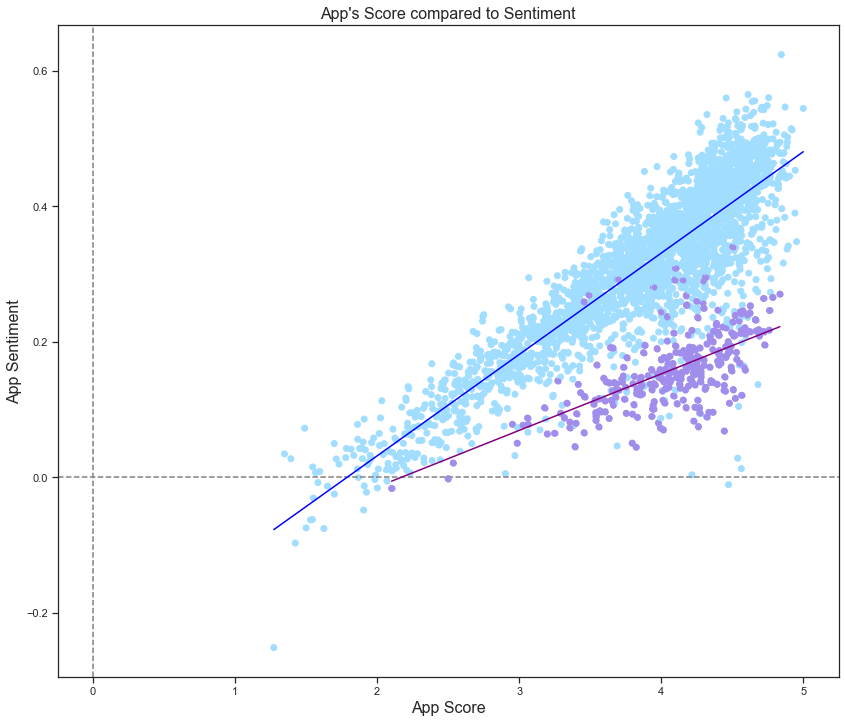

In [21]:
df_con_full = df_con_full.sort_values('Score')
colors = set_genre_colors(df_con_full,'Games')
# Scatter plot
sns.set_theme(style="ticks")
plt.figure(figsize=(14, 12))
plt.axvline(0,c=(0.5,0.5,0.5), ls='--')
plt.axhline(0,c=(0.5,0.5,0.5), ls='--')
sc = plt.scatter(df_con_full['Score'],df_con_full['TextSentiment'],color= colors)
plt.title('App\'s Score compared to Sentiment', fontsize=16)
plt.xlabel('App Score', fontsize=16)
plt.ylabel('App Sentiment', fontsize=16)

df_con_full_games = df_con_full.drop(df_con_full[df_con_full.Genre != 'Games'].index)
df_con_full_notgames = df_con_full.drop(df_con_full[df_con_full.Genre == 'Games'].index)

plt.plot(df_con_full_games['Score'], df_con_full_games['TextSentiment'], 'o', color = '#A18DEB',markersize=5)

#line of best fit
x = df_con_full_notgames['Score']
y = df_con_full_notgames['TextSentiment']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='blue')
print('Sentiment to Score line Slope: ', m)

#line of best fit
x = df_con_full_games['Score']
y = df_con_full_games['TextSentiment']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='purple')
print('Sentiment to Score line Slope Games: ', m)

plt.show()

The Games Genre seems to single handedly skew the line of best fit

# Genre's App Scores and Sentiment Scores

The next graphs plot the Apps in the Genres, with their App Score and Sentiment Score. Games Genre performing badly in Sentiment but relatively good in Score

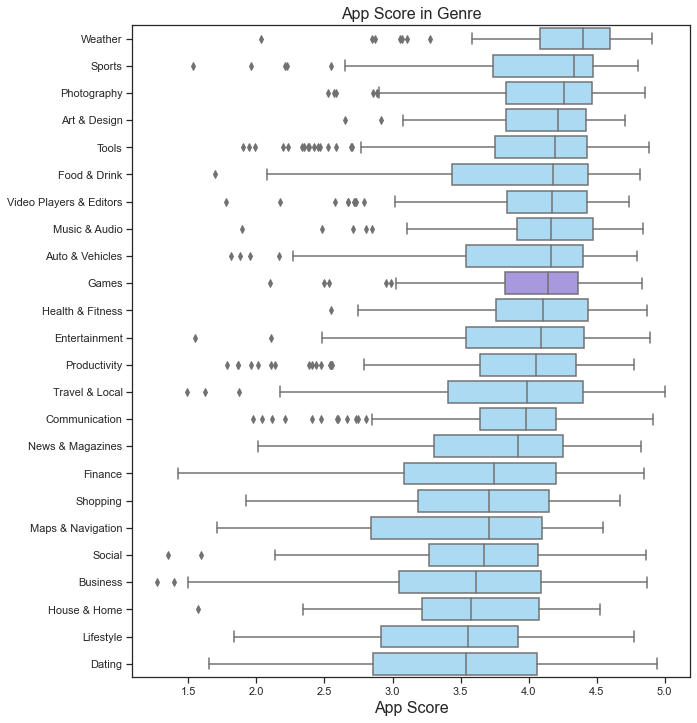

In [22]:
df_con_full_med = df_con_full.groupby('Genre').median()
df_con_full_med = pd.DataFrame(df_con_full_med).reset_index()
df_con_full_med = df_con_full_med.rename(columns={'index':'Genre'})
df_con_full_med = df_con_full_med.sort_values('Score',ascending=False)

colors = set_genre_colors(df_con_full_med,'Games')

fig, ax = plt.subplots(figsize=(10, 12))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Score", y="Genre", data=df_con_full,palette=colors,order = df_con_full_med['Genre'])   
plt.title('App Score in Genre', fontsize=16)
plt.xlabel('App Score', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

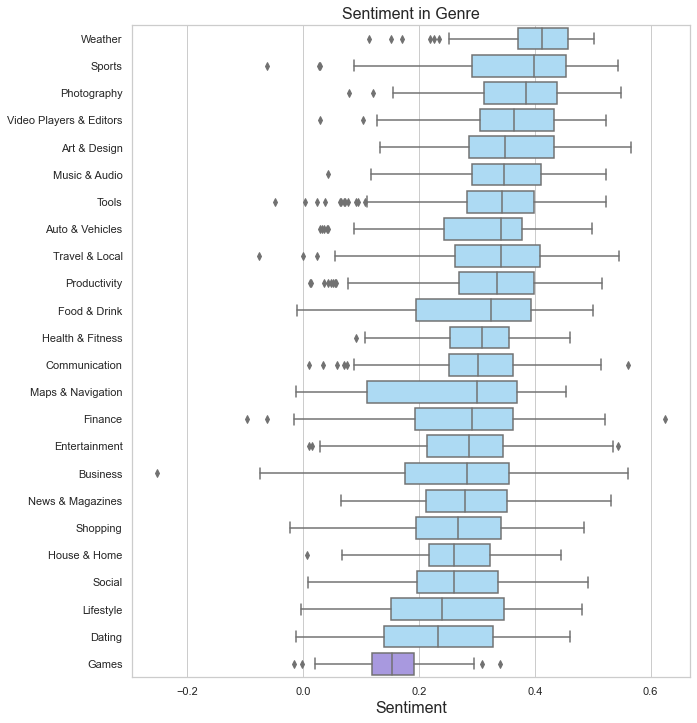

In [23]:
df_con_full_med = df_con_full.groupby('Genre').median()
df_con_full_med = pd.DataFrame(df_con_full_med).reset_index()
df_con_full_med = df_con_full_med.rename(columns={'index':'Genre'})
df_con_full_med = df_con_full_med.sort_values('TextSentiment',ascending=False)

colors = set_genre_colors(df_con_full_med,'Games')

fig, ax = plt.subplots(figsize=(10, 12))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="TextSentiment", y="Genre", data=df_con_full,palette=colors,order = df_con_full_med['Genre'])   
plt.title('Sentiment in Genre', fontsize=16)
plt.xlabel('Sentiment', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

# How many Reviews in each Genre?

In [24]:
#review star counts
def getGroupStars(num):
    df_remove = df.drop(df[df.Score != num].index)
    df_scores = df_remove.groupby('Genre')['Score'].count()
    df_scores = pd.DataFrame(df_scores).reset_index()
    df_scores = df_scores.rename(columns={'index':'Genre'})
    df_scores = df_scores.sort_values('Score')
    df_scores = df_scores.rename(columns={'Score':str(num)+' Stars'})
    return df_scores

df_scores5 = getGroupStars(5)
df_scores4 = getGroupStars(4)
df_scores3 = getGroupStars(3)
df_scores2 = getGroupStars(2)
df_scores1 = getGroupStars(1)

df_scores = df_scores5
df_scores['4 Stars'] = df_scores4['4 Stars']
df_scores['3 Stars'] = df_scores3['3 Stars']
df_scores['2 Stars'] = df_scores2['2 Stars']
df_scores['1 Stars'] = df_scores1['1 Stars']

df_scores['totalReviews'] = df_scores['5 Stars']+df_scores['4 Stars']+df_scores['3 Stars']+df_scores['2 Stars']+df_scores['1 Stars']
df_scores

,Genre,5 Stars,4 Stars,3 Stars,2 Stars,1 Stars,totalReviews
12,Maps & Navigation,10812,2000,1207,1120,5499,20638
10,House & Home,12509,2768,1469,1181,5186,23113
1,Auto & Vehicles,19868,3828,1885,1661,5831,33073
4,Dating,27980,3311,2446,2203,16776,52716
7,Food & Drink,31376,4564,2225,1850,10146,50161
0,Art & Design,31945,5849,2776,1777,6388,48735
11,Lifestyle,33128,6818,4489,3841,17514,65790
14,News & Magazines,34409,8322,4544,4068,12717,64060
9,Health & Fitness,37813,7931,3424,2277,6790,58235
2,Business,49886,7085,3807,2894,13214,76886


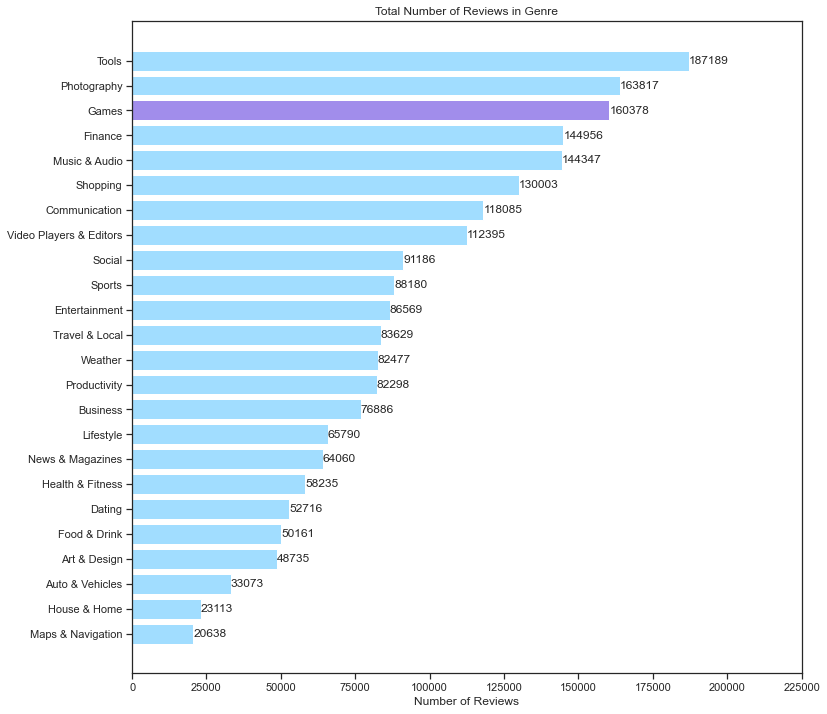

In [25]:
df_scores = df_scores.sort_values('totalReviews',ascending=False)

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(12, 12))

colors = set_genre_colors(df_scores,'Games')
y_pos = np.arange(len(df_scores['Genre']))

hbars = ax.barh(y_pos, df_scores['totalReviews'], align='center',color=colors)
ax.set_yticks(y_pos, labels=df_scores['Genre'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Reviews')
ax.set_title('Total Number of Reviews in Genre')

# Label with specially formatted floats
ax.bar_label(hbars)
ax.set_xlim(right=225000)  # adjust xlim to fit labels

plt.show()

# Good and Bad Reviews
Good Reviews are reviews that gave the app a rating of 4 or 5 stars, 
 Bad Reviews are reviews that gave the app a rating of 1 or 2 stars

In [26]:
#Percentages
df_scores['Good Review percentage'] = (df_scores['5 Stars']+df_scores['4 Stars']) / (df_scores['5 Stars']+
                                                         df_scores['4 Stars']+
                                                         df_scores['3 Stars']+
                                                         df_scores['2 Stars']+
                                                         df_scores['1 Stars'])

df_scores['Mid Review percentage'] = df_scores['3 Stars'] / (df_scores['5 Stars']+
                                                         df_scores['4 Stars']+
                                                         df_scores['3 Stars']+
                                                         df_scores['2 Stars']+
                                                         df_scores['1 Stars'])

df_scores['Bad Review percentage'] = (df_scores['1 Stars']+df_scores['2 Stars']) / (df_scores['5 Stars']+
                                                         df_scores['4 Stars']+
                                                         df_scores['3 Stars']+
                                                         df_scores['2 Stars']+
                                                         df_scores['1 Stars'])

df_scores

,Genre,5 Stars,4 Stars,3 Stars,2 Stars,1 Stars,totalReviews,Good Review percentage,Mid Review percentage,Bad Review percentage
20,Tools,123364,18445,9368,6195,29817,187189,0.757571,0.050046,0.192383
15,Photography,112674,15546,7869,5334,22394,163817,0.782703,0.048035,0.169262
8,Games,120521,11974,6346,4069,17468,160378,0.826142,0.039569,0.134289
6,Finance,83460,12030,6873,5742,36851,144956,0.658752,0.047414,0.293834
13,Music & Audio,95915,15888,8506,5101,18937,144347,0.774543,0.058927,0.166529
17,Shopping,78023,11399,6486,5532,28563,130003,0.687846,0.049891,0.262263
3,Communication,76457,11648,6684,4601,18695,118085,0.746115,0.056603,0.197282
22,Video Players & Editors,76388,11343,5385,3240,16039,112395,0.780560,0.047911,0.171529
18,Social,52281,7880,5491,4184,21350,91186,0.659761,0.060218,0.280021
19,Sports,57090,10290,4661,3176,12963,88180,0.764119,0.052858,0.183023


Text(0.5, 1.0, 'Good Review Reviews Percentage in Genre')

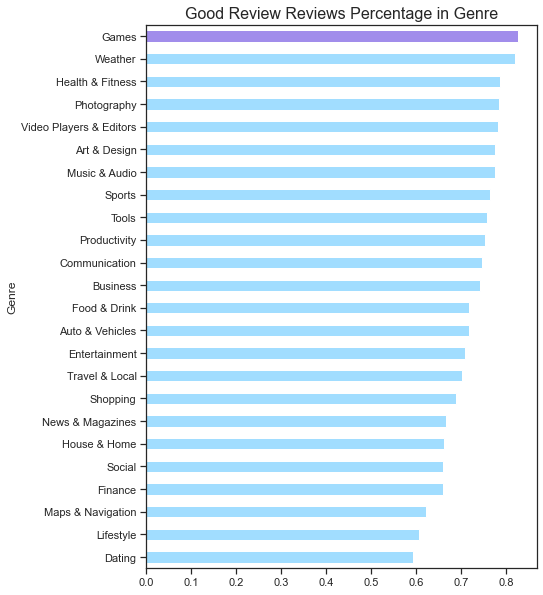

In [27]:
df_scores = df_scores.sort_values('Good Review percentage')
colors = set_genre_colors(df_scores,'Games')
ax = df_scores.plot.barh(x='Genre', y='Good Review percentage',color=colors, figsize=(7, 10), legend='')
plt.title('Good Review Reviews Percentage in Genre', fontsize=16)


Text(0.5, 1.0, 'Bad Review Reviews Percentage in Genre')

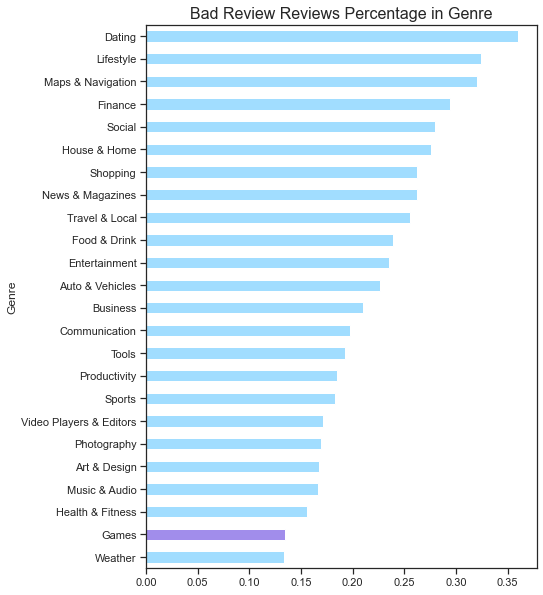

In [28]:
df_scores = df_scores.sort_values('Bad Review percentage')
colors = set_genre_colors(df_scores,'Games')
ax = df_scores.plot.barh(x='Genre', y='Bad Review percentage',color=colors, figsize=(7, 10), legend='')
plt.title('Bad Review Reviews Percentage in Genre', fontsize=16)

Text(0.5, 1.0, 'Good and Bad Review Percentage in Genre')

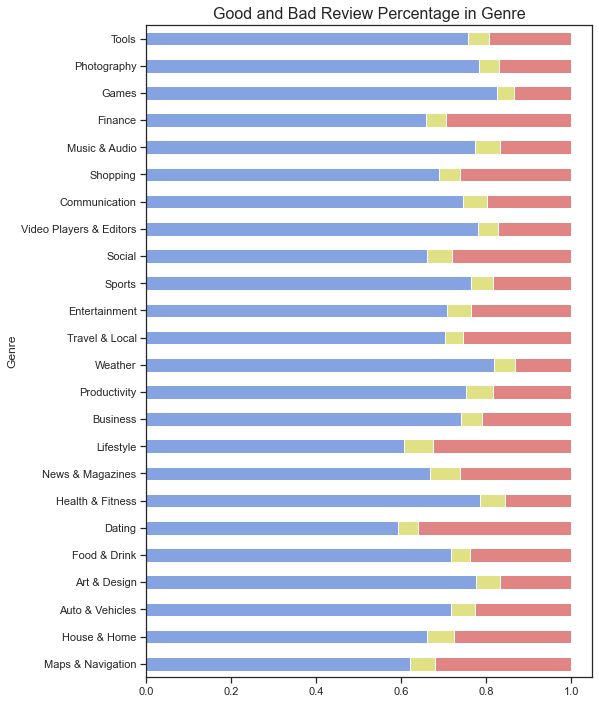

In [29]:
df_scores_percentage = df_scores.drop(columns=['5 Stars','4 Stars','3 Stars','2 Stars','1 Stars'])
df_scores_percentage = df_scores_percentage.sort_values('totalReviews')
df_scores_percentage = df_scores_percentage.drop(columns=['totalReviews'])
sns.set_theme(style="ticks")
ax = df_scores_percentage.plot.barh(x='Genre',stacked=True, figsize=(8, 12), color=[(0.2, 0.4, 0.8, 0.6),
                                                        (0.8, 0.8, 0.2, 0.6),
                                                       (0.8, 0.2, 0.2, 0.6)])
ax.get_legend().remove()
plt.title('Good and Bad Review Percentage in Genre', fontsize=16)

# Sentiment Score in Good and Bad Reviews

In [30]:
df['ThumbsUpCount'] = pd.to_numeric(df['ThumbsUpCount'], downcast="float")

df_goodReviews = df.drop(df[df.Score < 4].index)
df_badReviews = df.drop(df[df.Score > 2].index)

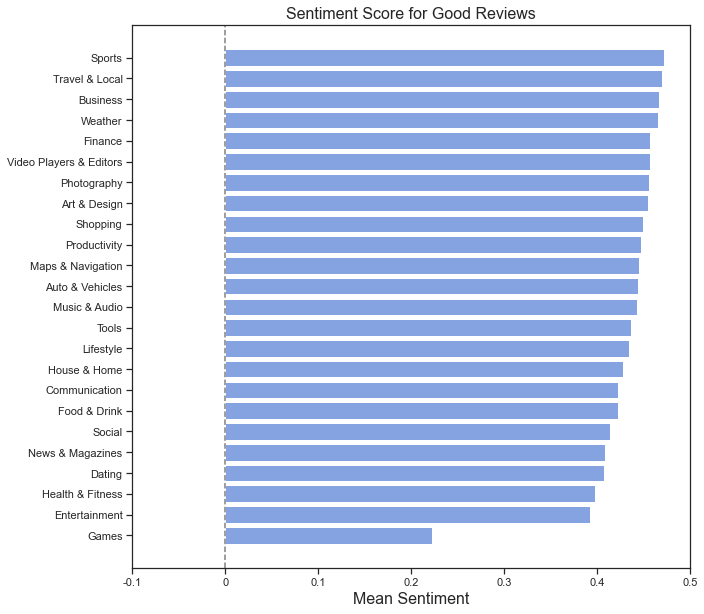

In [31]:
df_goodReviews_means = df_goodReviews.groupby('Genre').mean()
df_goodReviews_means = pd.DataFrame(df_goodReviews_means).reset_index()
df_goodReviews_means = df_goodReviews_means.rename(columns={'index':'Genre'})
df_goodReviews_means = df_goodReviews_means.sort_values('TextSentiment')

colors = (0.2, 0.4, 0.8, 0.6)
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(0,c=(0.5,0.5,0.5), ls='--')
ax.barh(df_goodReviews_means['Genre'], df_goodReviews_means['TextSentiment'], color=colors)
plt.xticks([-0.1,0,0.1,0.2,0.3,0.4,0.5],
           [-0.1,0,0.1,0.2,0.3,0.4,0.5])
plt.title('Sentiment Score for Good Reviews', fontsize=16)
plt.xlabel('Mean Sentiment', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

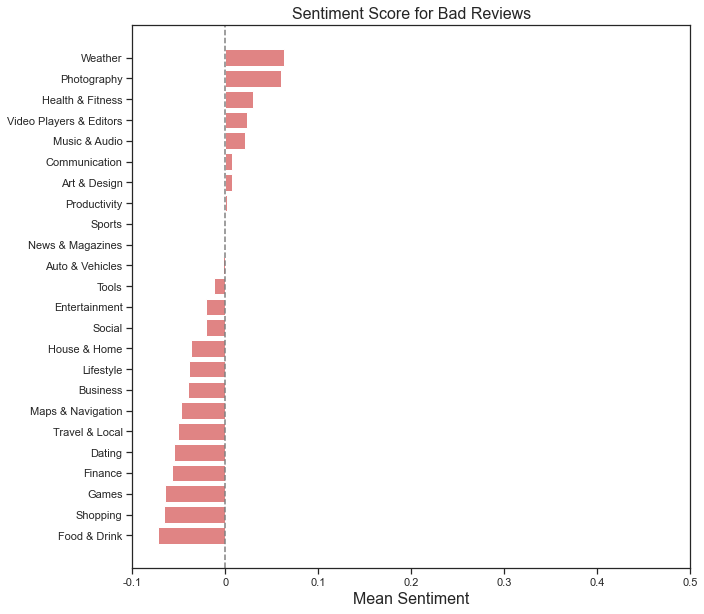

In [32]:
df_badReviews_means = df_badReviews.groupby('Genre').mean()
df_badReviews_means = pd.DataFrame(df_badReviews_means).reset_index()
df_badReviews_means = df_badReviews_means.rename(columns={'index':'Genre'})
df_badReviews_means = df_badReviews_means.sort_values('TextSentiment')

colors = (0.8, 0.2, 0.2, 0.6)
fig, ax = plt.subplots(figsize=(10, 10))
plt.axvline(0,c=(0.5,0.5,0.5), ls='--')
ax.barh(df_badReviews_means['Genre'], df_badReviews_means['TextSentiment'], color=colors)
plt.xticks([-0.1,0,0.1,0.2,0.3,0.4,0.5],
           [-0.1,0,0.1,0.2,0.3,0.4,0.5])
plt.title('Sentiment Score for Bad Reviews', fontsize=16)
plt.xlabel('Mean Sentiment', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

# Review Likes compared to Review Sentiment and Score

This graph shows the ratio of likes on good reviews to bad reviews, for every 1 like on a good review there is this many on a bad review

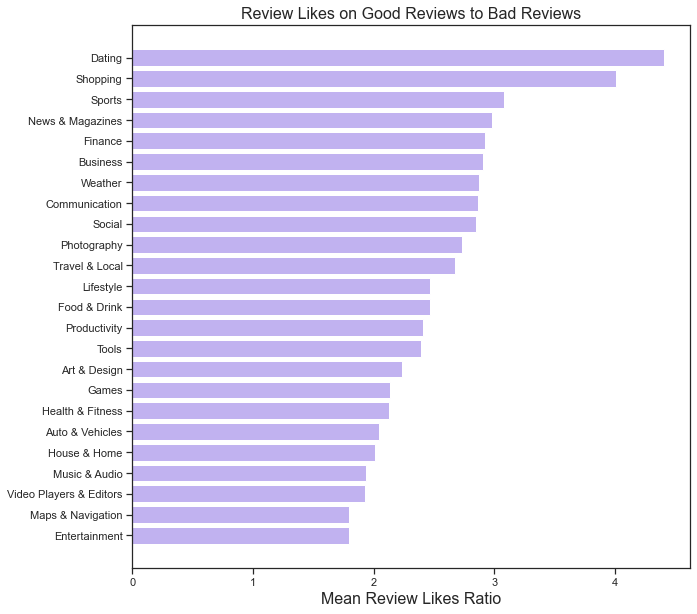

In [33]:
df_goodReviews_means = df_goodReviews_means.sort_values('Genre')
df_badReviews_means = df_badReviews_means.sort_values('Genre')

df_ratio=[]
df_ratio = df_goodReviews_means.sort_values('Genre')
df_ratio['ThumbsUpRatio'] = df_badReviews_means['ThumbsUpCount']/df_goodReviews_means['ThumbsUpCount']
df_ratio = df_ratio.sort_values('ThumbsUpRatio')

colors = (0.6, 0.5, 0.9, 0.6)
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(df_ratio['Genre'], df_ratio['ThumbsUpRatio'], color=colors)
plt.title('Review Likes on Good Reviews to Bad Reviews', fontsize=16)
plt.xlabel('Mean Review Likes Ratio', fontsize=16)
plt.ylabel('', fontsize=16)
plt.show()

# Very Positive Review and Very Negative Reviews' Likes
A Very Positive Review is a 4 or 5 star review with a sentiment score higher than the median sentiment of that genre,
a Very Negative Review is a 1 or 2 star review with a sentiment score lower than the median sentiment of that genre

In [34]:
df_sent_med = df_con_full.groupby('Genre').median()
df_sent_med = pd.DataFrame(df_sent_med).reset_index()
df_sent_med = df_sent_med.rename(columns={'index':'Genre'})

def get_medianGenreSentiment(genre):
    return list(df_sent_med.loc[df_sent_med['Genre'] == genre]['TextSentiment'])[0]

    
df2 = df
df2['MedianGenreSentiment']=np.nan
df2['MedianGenreSentiment'] = df2['Genre'].apply(get_medianGenreSentiment)
df2.head(3)

,AppId,AppScore,Price,AdSupported,OffersIAP,InAppProductPrice Low,InAppProductPrice High,Genre,SubGenre,ReviewId,Username,ReviewText,Score,ThumbsUpCount,ReviewCreatedVersion,ReceivedReply,Time,ReviewTextTokenized,TextSentiment,MedianGenreSentiment
0,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOFmCWceVoFZy8SeT12c-I66JbSj0Nf7-hnVE4B...,Malesha Hasan,Excellent app to use. No problems.,5.0,0.0,105.0,False,2022-04-09 18:23:54,"[problems, use, excellent]",1.0,0.282597
1,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOE7iZydz6Vu-dbOYpLejv8suWqfV0x9dVhIg05...,Melanie Zokem,Stronger Good but slow,5.0,0.0,104.0,False,2022-04-09 18:16:21,"[slow, good, stronger]",0.2,0.282597
2,com.indeed.android.jobsearch,4.653203,0,True,False,0.0,0.0,Business,Business,gp:AOqpTOEzc9TbIqE7koJWizuWQy-ot_uB_od_CBQ3Tai...,JOHN JACOB,Submitted many times,5.0,0.0,105.0,False,2022-04-09 18:07:13,"[times, submitted, many]",0.5,0.282597


In [35]:
df_posReviews = df2.drop(df2[df2.TextSentiment <= df2.MedianGenreSentiment].index)
df_negReviews = df2.drop(df2[df2.TextSentiment >= df2.MedianGenreSentiment].index)

#removing reviews that may not have a correct sentiment calculation
#example, 4 or 5 star review 'not bad' returns a negative sentiment
df_posReviews = df_posReviews.drop(df_posReviews[df_posReviews.Score < 3].index)
df_negReviews = df_negReviews.drop(df_negReviews[df_negReviews.Score > 3].index)

Text(0, 0.5, '')

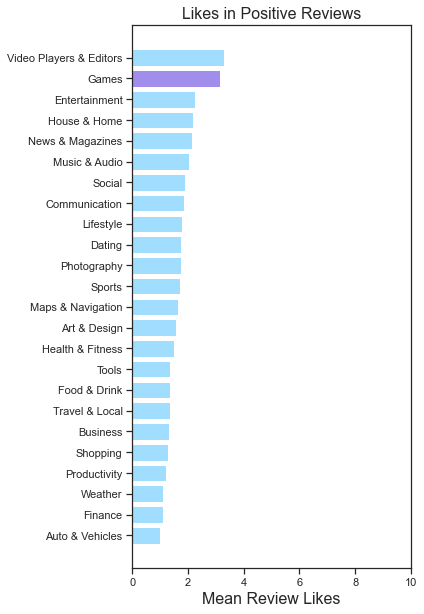

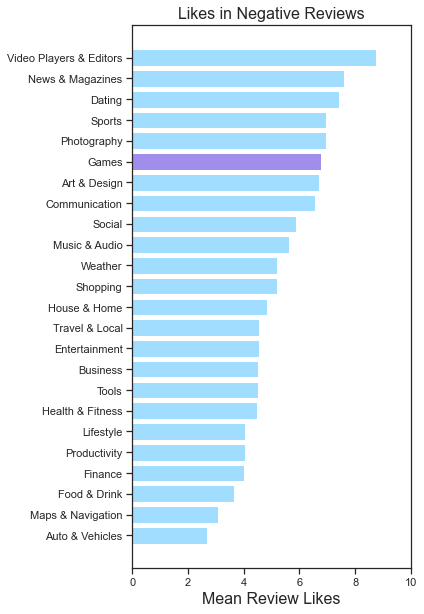

In [36]:
df_posReviews_means = df_posReviews.groupby('Genre').mean()
df_posReviews_means = pd.DataFrame(df_posReviews_means).reset_index()
df_posReviews_means = df_posReviews_means.rename(columns={'index':'Genre'})

df_negReviews_means = df_negReviews.groupby('Genre').mean()
df_negReviews_means = pd.DataFrame(df_negReviews_means).reset_index()
df_negReviews_means = df_negReviews_means.rename(columns={'index':'Genre'})

df_posReviews_means = df_posReviews_means.sort_values('Genre')
df_negReviews_means = df_negReviews_means.sort_values('Genre')

df_ratio2=[]
df_ratio2 = df_posReviews_means.sort_values('Genre')
df_ratio2['ThumbsUpRatio'] = df_negReviews_means['ThumbsUpCount']/df_posReviews_means['ThumbsUpCount']

df_posReviews_means = df_posReviews_means.sort_values('ThumbsUpCount')
colors = set_genre_colors(df_posReviews_means,'Games')
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(df_posReviews_means['Genre'], df_posReviews_means['ThumbsUpCount'], color=colors)
plt.xticks([0,2,4,6,8,10],
           [0,2,4,6,8,10])
plt.title('Likes in Positive Reviews', fontsize=16)
plt.xlabel('Mean Review Likes', fontsize=16)
plt.ylabel('', fontsize=16)

df_negReviews_means = df_negReviews_means.sort_values('ThumbsUpCount')
colors = set_genre_colors(df_negReviews_means,'Games')
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(df_negReviews_means['Genre'], df_negReviews_means['ThumbsUpCount'], color=colors)
plt.xticks([0,2,4,6,8,10],
           [0,2,4,6,8,10])
plt.title('Likes in Negative Reviews', fontsize=16)
plt.xlabel('Mean Review Likes', fontsize=16)
plt.ylabel('', fontsize=16)

Text(0, 0.5, '')

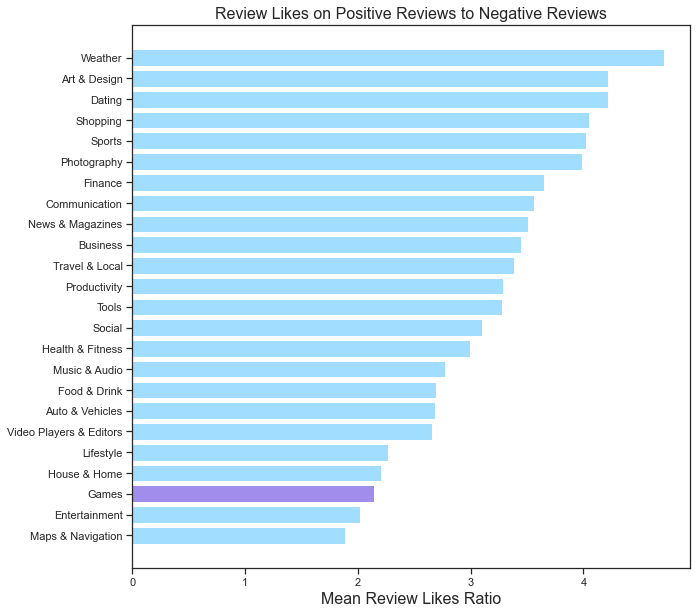

In [37]:
df_ratio2 = df_ratio2.sort_values('ThumbsUpRatio')
colors = set_genre_colors(df_ratio2,'Games')
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(df_ratio2['Genre'], df_ratio2['ThumbsUpRatio'], color=colors)
plt.title('Review Likes on Positive Reviews to Negative Reviews', fontsize=16)
plt.xlabel('Mean Review Likes Ratio', fontsize=16)
plt.ylabel('', fontsize=16)

# Saving as new dataset for next Research Questions

In [ ]:
df.to_pickle('appReviews_dataset_after_rq1.pkl')